In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import os

import random

random.seed(42)
pd.set_option('display.max_columns', None)

def count_decimal_places(num, *, remove_single_zero=False):
    str_num = str(num)
    if remove_single_zero and str_num.endswith('.0'):
        return 0
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

pd.set_option('display.float_format', lambda x: '{:.{}f}'.format(x, min(count_decimal_places(x), 6)))

In [34]:
def load_dataset_ping_echo(path, params):
    if path.endswith('.v1.txt'):
        data = pd.read_csv(path, sep=' ', header=None, names=['Latency', 'Sequence'], skiprows=lambda n: not n % 2)
    elif path.endswith('.v2.txt'):
        data = pd.read_csv(path, sep=' ', header=None, names=['Latency', 'Sequence'])
    elif path.endswith('.v3.txt'):
        data = pd.read_csv(path, sep=',', header=None, names=['Sequence', 'Latency'])
    else:
        return pd.DataFrame()

    data['Workload'] = params['Workload']
    data['Mode'] = params['Mode']
    data['Scenario'] = params['Scenario']
    data['Iteration'] = params['Iteration']
    return data

def load_dataset(path, params):
    if params['Workload'] == 'ping-echo':
        return load_dataset_ping_echo(path, params)
    return pd.DataFrame()

def log_parameters_from_filename(filename):
    parts = filename.split('-')

    if len(parts) != 4: return None

    return {
        'Mode': parts[1],
        'Scenario': parts[2],
        'Iteration': int(parts[3].split('.')[0])
    }

WORKLOADS_BASE = '../workloads'

df_list = [
    pd.DataFrame({ k: [] for k in ['Workload', 'Iteration', 'Mode', 'Scenario', 'Latency'] }),
]

for workload in os.listdir(WORKLOADS_BASE):
    logs_path = os.path.join(WORKLOADS_BASE, workload, 'logs')

    if not os.path.isdir(logs_path): continue

    for log_file in os.listdir(logs_path):
        log_parameters = log_parameters_from_filename(log_file)

        if log_parameters is None: continue

        log_parameters['Workload'] = workload
        df = load_dataset(os.path.join(logs_path, log_file), log_parameters)
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df

,Workload,Iteration,Mode,Scenario,Latency,Sequence
0,ping-echo,6.0,none,baseline,677806.0,0.0
1,ping-echo,6.0,none,baseline,420651.0,1.0
2,ping-echo,6.0,none,baseline,451801.0,2.0
3,ping-echo,6.0,none,baseline,447191.0,3.0
4,ping-echo,6.0,none,baseline,434968.0,4.0
...,...,...,...,...,...,...
8758,ping-echo,7.0,ztunnel,optimization,410389.0,2070.0
8759,ping-echo,7.0,ztunnel,optimization,618586.0,2071.0
8760,ping-echo,7.0,ztunnel,optimization,507120.0,2072.0
8761,ping-echo,7.0,ztunnel,optimization,239557.0,2073.0


In [35]:
df['Scenario'] = df.Scenario.str.capitalize()
df['Mode'] = df.Mode.map(lambda x: {'none': 'No Service Mesh', 'ztunnel': 'Ambient Mesh'}[x])

In [37]:
df.groupby(['Mode', 'Scenario'])[['Mode']].count()

Mode
Mode            Scenario          
Ambient Mesh    Baseline      2129
                Optimization  2075
No Service Mesh Baseline      2413
                Optimization  2146

In [44]:
df['Latency_diff'] = df.groupby(['Mode', 'Scenario']).Latency.diff().abs().fillna(0)
df

,Workload,Iteration,Mode,Scenario,Latency,Sequence,Latency_diff
0,ping-echo,6.0,No Service Mesh,Baseline,677806.0,0.0,0.0
1,ping-echo,6.0,No Service Mesh,Baseline,420651.0,1.0,257155.0
2,ping-echo,6.0,No Service Mesh,Baseline,451801.0,2.0,31150.0
3,ping-echo,6.0,No Service Mesh,Baseline,447191.0,3.0,4610.0
4,ping-echo,6.0,No Service Mesh,Baseline,434968.0,4.0,12223.0
...,...,...,...,...,...,...,...
8758,ping-echo,7.0,Ambient Mesh,Optimization,410389.0,2070.0,304649.0
8759,ping-echo,7.0,Ambient Mesh,Optimization,618586.0,2071.0,208197.0
8760,ping-echo,7.0,Ambient Mesh,Optimization,507120.0,2072.0,111466.0
8761,ping-echo,7.0,Ambient Mesh,Optimization,239557.0,2073.0,267563.0


In [66]:
df.Latency.quantile(.99), df.Latency.max()

(np.float64(745289.7999999998), np.float64(1191078.0))

In [40]:
latency_p99 = df[df.Latency <= df.Latency.quantile(.99)]

In [41]:
latency_p99.groupby(['Mode', 'Scenario']).Latency.agg(
    p25=lambda column: column.quantile(.25),
    p50=lambda column: column.quantile(.50),
    p75=lambda column: column.quantile(.75),
)

p25      p50       p75
Mode            Scenario                                
Ambient Mesh    Baseline     442691.0 485818.0  537116.5
                Optimization 351513.0 382103.0  423659.0
No Service Mesh Baseline     443983.0 481832.0  529713.5
                Optimization 368605.5 399145.0 452569.75

In [42]:
jitter = latency_p99.groupby(['Mode', 'Scenario']).Latency.std(ddof=0)
jitter

Mode             Scenario    
Ambient Mesh     Baseline       88440.404120
                 Optimization   79792.937463
No Service Mesh  Baseline       83247.877712
                 Optimization   80861.114336
Name: Latency, dtype: float64

In [45]:
latency_diff_p99 = df[df.Latency_diff <= df.Latency_diff.quantile(.99)]

In [46]:
print('removed entries > p99 latency:')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count() - latency_p99.groupby(['Mode', 'Scenario'])[['Latency']].count())

print('total')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count())

removed entries > p99 latency:


Latency
Mode            Scenario             
Ambient Mesh    Baseline           30
                Optimization       10
No Service Mesh Baseline           42
                Optimization        6

total


Latency
Mode            Scenario             
Ambient Mesh    Baseline         2129
                Optimization     2075
No Service Mesh Baseline         2413
                Optimization     2146

In [47]:
df[df.Latency > df.Latency.quantile(.99)]

,Workload,Iteration,Mode,Scenario,Latency,Sequence,Latency_diff
64,ping-echo,6.0,No Service Mesh,Baseline,760287.0,64.0,123409.0
67,ping-echo,6.0,No Service Mesh,Baseline,774116.0,67.0,313725.0
73,ping-echo,6.0,No Service Mesh,Baseline,749183.0,73.0,191294.0
94,ping-echo,6.0,No Service Mesh,Baseline,848985.0,94.0,321268.0
106,ping-echo,6.0,No Service Mesh,Baseline,752395.0,106.0,274614.0
...,...,...,...,...,...,...,...
7868,ping-echo,7.0,Ambient Mesh,Optimization,887965.0,1180.0,336985.0
8185,ping-echo,7.0,Ambient Mesh,Optimization,991610.0,1497.0,593094.0
8222,ping-echo,7.0,Ambient Mesh,Optimization,871483.0,1534.0,509145.0
8288,ping-echo,7.0,Ambient Mesh,Optimization,788791.0,1600.0,243538.0


In [48]:
print('removed entries > p99 latency diff:')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count() - latency_diff_p99.groupby(['Mode', 'Scenario'])[['Latency']].count())

print('total')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count())

removed entries > p99 latency diff:


Latency
Mode            Scenario             
Ambient Mesh    Baseline           21
                Optimization       32
No Service Mesh Baseline           21
                Optimization       14

total


Latency
Mode            Scenario             
Ambient Mesh    Baseline         2129
                Optimization     2075
No Service Mesh Baseline         2413
                Optimization     2146

In [49]:
df[df.Latency_diff > df.Latency_diff.quantile(.99)]

,Workload,Iteration,Mode,Scenario,Latency,Sequence,Latency_diff
179,ping-echo,6.0,No Service Mesh,Baseline,421559.0,179.0,382797.0
229,ping-echo,6.0,No Service Mesh,Baseline,248005.0,229.0,439089.0
546,ping-echo,6.0,No Service Mesh,Baseline,863311.0,546.0,420795.0
547,ping-echo,6.0,No Service Mesh,Baseline,400611.0,547.0,462700.0
607,ping-echo,6.0,No Service Mesh,Baseline,899979.0,607.0,433437.0
...,...,...,...,...,...,...,...
8370,ping-echo,7.0,Ambient Mesh,Optimization,743673.0,1682.0,516339.0
8371,ping-echo,7.0,Ambient Mesh,Optimization,266585.0,1683.0,477088.0
8524,ping-echo,7.0,Ambient Mesh,Optimization,332376.0,1836.0,368275.0
8742,ping-echo,7.0,Ambient Mesh,Optimization,240534.0,2054.0,511589.0


In [50]:
def format_ns(ns, to):
    convert_table = {
        'ns': 1,
        'us': 1 / 1_000,
        'ms': 1 / 1_000_000,
         's': 1 / 1_000_000_000,
    }
    number = ns * convert_table[to]
    return '{:.{}f}'.format(number, min(count_decimal_places(number, remove_single_zero=True), 6))

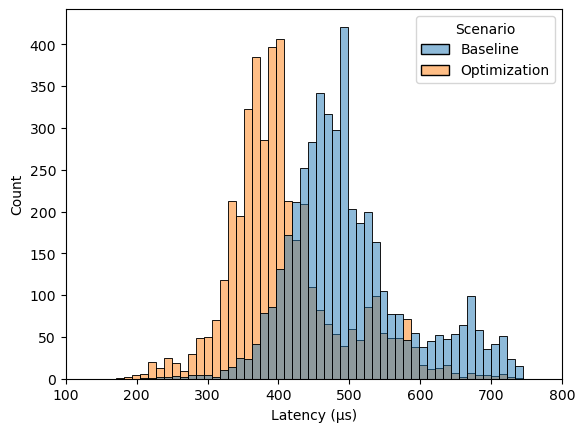

In [61]:
g = sns.histplot(data=latency_p99, x='Latency', hue='Scenario')

g.set_xticks(g.get_xticks())
g.set(
    #title='Latency -- p99',
    xlabel='Latency (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

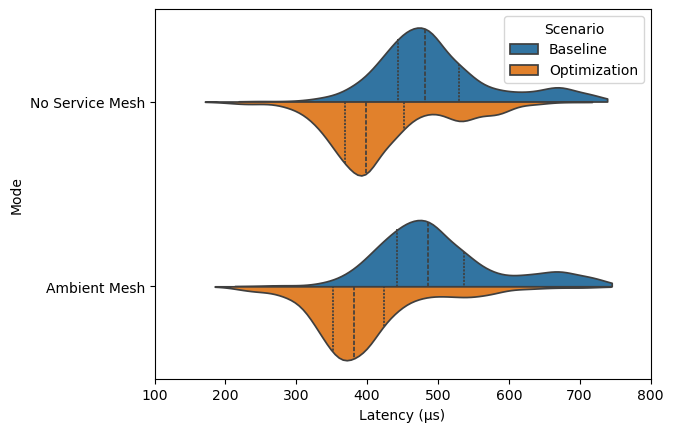

In [65]:
g = sns.violinplot(data=latency_p99, x='Latency', y='Mode', split=True, hue='Scenario', inner='quart', cut=0)

g.set_xticks(g.get_xticks())
g.set(
    #title='Latency -- p99',
    xlabel='Latency (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

g.figure.savefig('ping-echo-violinplot-latency.svg', bbox_inches='tight')

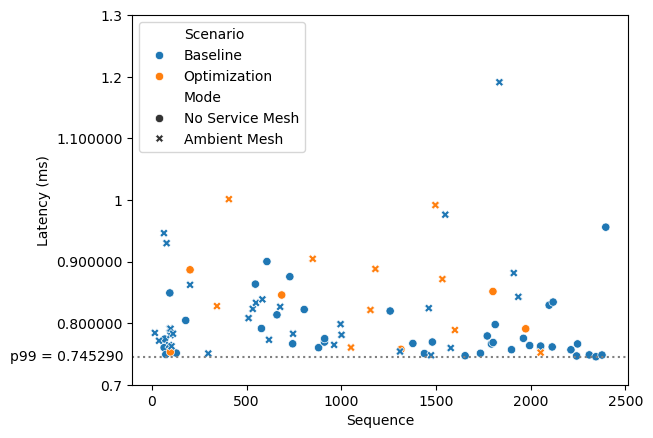

In [63]:
latency_outliers = df[df.Latency > df.Latency.quantile(.99)]
g = sns.scatterplot(data=latency_outliers, x='Sequence', y='Latency', hue='Scenario', style='Mode')

g.axhline(y=df.Latency.quantile(.99), linewidth=1.5, color='gray', ls=':')
g.text(-150, df.Latency.quantile(.99), f"p99 = {format_ns(df.Latency.quantile(.99), 'ms')}", va='center', ha='right')

g.set_yticks(g.get_yticks())
g.set(
    #title='Latency -- >p99',
    ylabel='Latency (ms)',
    #xlabel='Sequence',
    yticklabels=[format_ns(tick, 'ms') for tick in g.get_yticks()],
);

g.figure.savefig('ping-echo-lineplot-latency-spikes.svg', bbox_inches='tight')

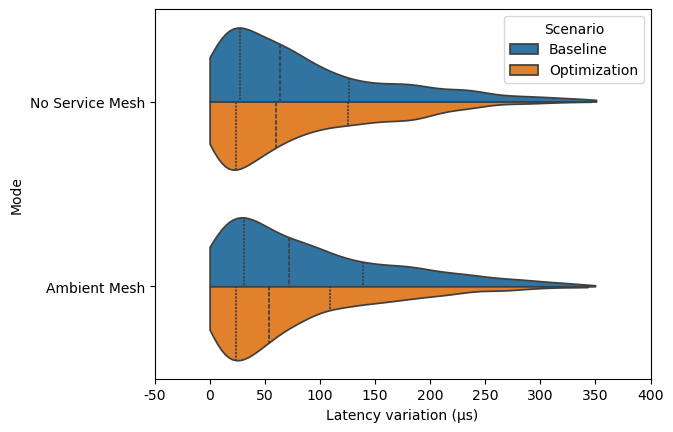

In [64]:
g = sns.violinplot(data=latency_diff_p99, x='Latency_diff', y='Mode', split=True, hue='Scenario', inner='quart', cut=0)

g.set_xticks(g.get_xticks())
g.set(
    #title='Latency -- p99',
    xlabel='Latency variation (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

g.figure.savefig('ping-echo-violinplot-jitter.svg', bbox_inches='tight')

In [67]:
jitter['No Service Mesh'].Optimization , jitter['No Service Mesh'].Baseline

(np.float64(80861.11433578489), np.float64(83247.87771170317))